Extracting input/data/train-images-idx3-ubyte.gz
Extracting input/data/train-labels-idx1-ubyte.gz
Extracting input/data/t10k-images-idx3-ubyte.gz
Extracting input/data/t10k-labels-idx1-ubyte.gz
9999                                                                                                                                                                                                                                                                                                     

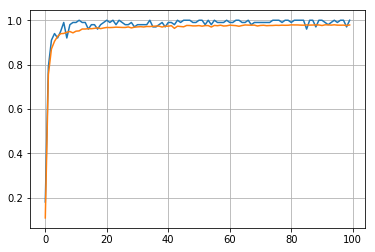

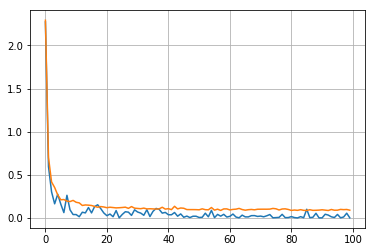

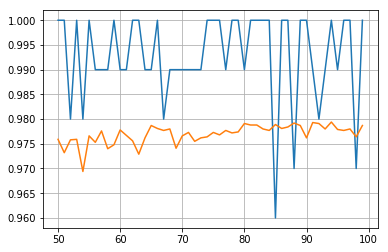

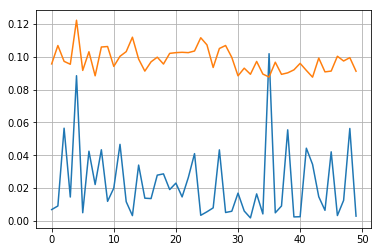

In [4]:
# all tensorflow api is accessible through this
import tensorflow as tf        
# to visualize the resutls
import matplotlib.pyplot as plt 
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data


IMAGE_SIZE = 28
NUM_CHANNELS = 1

tf.set_random_seed(0)

# load data
mnist = input_data.read_data_sets('input/data', one_hot=True)

# 1. Define Variables and Placeholders
X = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS]) #the first dimension (None) will index the images
# correct answers
Y_ = tf.placeholder(tf.float32, [None, 10])

# Weights initialised with small random values between -0.2 and +0.2
W1 = tf.Variable(tf.truncated_normal([784, 200], stddev=0.1)) # 784 = 28 * 28
B1 = tf.Variable(tf.zeros([200]))
W2 = tf.Variable(tf.truncated_normal([200, 100], stddev=0.1))
B2 = tf.Variable(tf.zeros([100]))
W3 = tf.Variable(tf.truncated_normal([100, 60], stddev=0.1))
B3 = tf.Variable(tf.zeros([60]))
W4 = tf.Variable(tf.truncated_normal([60, 30], stddev=0.1))
B4 = tf.Variable(tf.zeros([30]))
W5 = tf.Variable(tf.truncated_normal([30, 10], stddev=0.1))
B5 = tf.Variable(tf.zeros([10]))

#learning rate placeholder
globalStep = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(0.5, globalStep, 10000, 0.96, staircase = True)
# placeholder for probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
pkeep = tf.placeholder(tf.float32)

XX = tf.reshape(X, [-1, 784])

# 2. Define the model

Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1)
Y1d = tf.nn.dropout(Y1, pkeep)
Y2 = tf.nn.relu(tf.matmul(Y1d, W2) + B2)
Y2d = tf.nn.dropout(Y2, pkeep)
Y3 = tf.nn.relu(tf.matmul(Y2d, W3) + B3)
Y3d = tf.nn.dropout(Y3, pkeep)
Y4 = tf.nn.relu(tf.matmul(Y3d, W4) + B4)
Y4d = tf.nn.dropout(Y4, pkeep)
Ylogits = tf.matmul(Y4d, W5) + B5
Y = tf.nn.softmax(Ylogits)


# 3. Define the loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = Y_, logits = Ylogits) # calculate cross-entropy with logits
cross_entropy = tf.reduce_mean(cross_entropy)

# 4. Define the accuracy
is_correct = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

# 5. Define an optimizer
optimizer = tf.train.GradientDescentOptimizer(lr)
train_step = optimizer.minimize(cross_entropy, global_step = globalStep)

# 3. In the training step - provide the appropriate pkeep

# 4. In the training step, if you used a placeholder - adjust learning rate - according to exponential decay rate
# initialize
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


def training_step(i, update_test_data, update_train_data):

    print "\r", i,
    ####### actual learning 
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    # the backpropagation training step
    sess.run(train_step, feed_dict={XX: batch_X, Y_: batch_Y, pkeep: 0.75})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={XX: batch_X, Y_: batch_Y, pkeep: 1})
        train_a.append(a)
        train_c.append(c)

    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={XX: mnist.test.images, Y_: mnist.test.labels, pkeep: 1})
        test_a.append(a)
        test_c.append(c)

    
    return (train_a, train_c, test_a, test_c)


# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []
    
training_iter = 10000
epoch_size = 100
for i in range(training_iter):
    test = False
    if i % epoch_size == 0:
        test = True
    a, c, ta, tc = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc
    
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.plot(train_a)
plt.plot(test_a)
plt.grid(True)
plt.show()

# loss training vs testing dataset
plt.plot(train_c)
plt.plot(test_c)
plt.grid(True)
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:])
plt.plot(x_range, test_a[zoom_point:])
plt.grid(True)
plt.show()

plt.plot(train_c[zoom_point:])
plt.plot(test_c[zoom_point:])
plt.grid(True)
plt.show()